Categories: ['Annotations', 'DataclusterFireAndSmokeSample']
Data Counts by Category: {'Annotations': 1, 'DataclusterFireAndSmokeSample': 1}


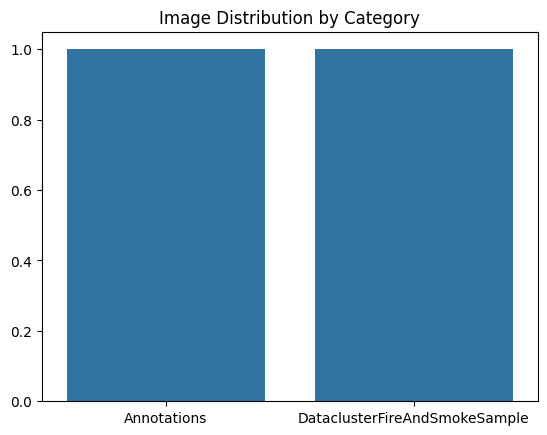

<Figure size 1200x800 with 0 Axes>

In [24]:
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd

# Step 1: Define dataset path (use raw string or double backslashes)
dataset_path = r'C:\Users\shamb\Desktop\forestfiredetection1\archive (24)'

# Step 2: Load dataset categories
categories = os.listdir(dataset_path)
print(f"Categories: {categories}")

# Step 3: Count images in each category
data_counts = {}
for category in categories:
    category_path = os.path.join(dataset_path, category)
    data_counts[category] = len(os.listdir(category_path))

# Display distribution of images across categories
print("Data Counts by Category:", data_counts)
sns.barplot(x=list(data_counts.keys()), y=list(data_counts.values()))
plt.title("Image Distribution by Category")
plt.show()

# Step 4: Visualize sample images from each category
def show_sample_images(categories, dataset_path):
    plt.figure(figsize=(12, 8))
    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        
        # Get the first valid image file in the category folder
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            img = cv2.imread(file_path)
            if img is not None:  # Check if the image was loaded successfully
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.subplot(1, len(categories), i+1)
                plt.imshow(img)
                plt.title(category)
                plt.axis('off')
                break  # Stop after loading the first valid image
    plt.show()

show_sample_images(categories, dataset_path)


Found 100 images belonging to 2 classes.


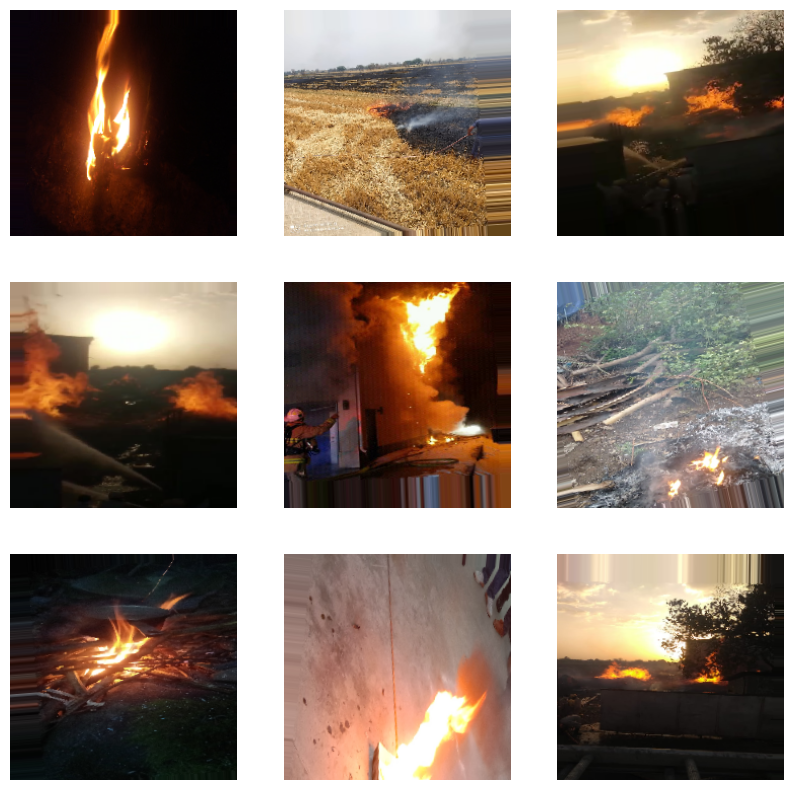

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data augmentation settings
datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=15,         # Rotate images up to 15 degrees
    width_shift_range=0.1,     # Shift width by up to 10%
    height_shift_range=0.1,    # Shift height by up to 10%
    shear_range=0.1,           # Apply shearing transformation
    zoom_range=0.1,            # Zoom in or out by 10%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill empty pixels after transformations
)

# Load and augment training images from directory
train_data_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),      # Adjust based on model input requirements
    batch_size=32,
    class_mode='categorical'     # Use 'binary' for two categories
)

# Example: Visualize augmented images
import matplotlib.pyplot as plt

# Fetch a batch of images and labels
images, labels = next(train_data_gen)

# Plot the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


In [6]:
from tensorflow.keras.applications import VGG16, InceptionV3, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Number of output classes
num_classes = 4

# Function to create the modified model
def create_model(base_model_class, input_shape=(224, 224, 3), num_classes=4):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Additional dense layer
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer
    
    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Create models using different pre-trained architectures
vgg16_model = create_model(VGG16, input_shape=(224, 224, 3), num_classes=num_classes)
inceptionv3_model = create_model(InceptionV3, input_shape=(299, 299, 3), num_classes=num_classes)
xception_model = create_model(Xception, input_shape=(299, 299, 3), num_classes=num_classes)

# Summary of models
print("VGG16 Model:")
vgg16_model.summary()
print("\nInceptionV3 Model:")
inceptionv3_model.summary()
print("\nXception Model:")
xception_model.summary()


VGG16 Model:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,766,852 (60.15 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


InceptionV3 Model:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 24,427,812 (93.18 MB)

 Trainable params: 2,625,028 (10.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)


Xception Model:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 23,486,508 (89.59 MB)

 Trainable params: 2,625,028 (10.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [26]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16, InceptionV3, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dataset directory
data_dir = r'C:\Users\shamb\Desktop\forestfiredetection1'  

# Verify the dataset directory exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The specified dataset directory '{data_dir}' does not exist.")

# Image size and batch size
img_size = (224, 224)  # Suitable for VGG16 and InceptionV3
batch_size = 32

# Data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Split dataset into training and validation
)

# Data generators
train_gen = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
)

val_gen = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
)

# Function to build LwF model
def build_lwf_model(base_model, num_classes):
    base_model.trainable = False  # Freeze the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

# Load pre-trained models and adapt them
num_classes = len(train_gen.class_indices)

# VGG16
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=img_size + (3,))
vgg16_model = build_lwf_model(vgg16_base, num_classes)

# InceptionV3
inceptionv3_base = InceptionV3(weights="imagenet", include_top=False, input_shape=img_size + (3,))
inceptionv3_model = build_lwf_model(inceptionv3_base, num_classes)

# Xception
xception_base = Xception(weights="imagenet", include_top=False, input_shape=img_size + (3,))
xception_model = build_lwf_model(xception_base, num_classes)

# Compile models
def compile_model(model):
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

vgg16_model = compile_model(vgg16_model)
inceptionv3_model = compile_model(inceptionv3_model)
xception_model = compile_model(xception_model)

# Train the models (example with VGG16)
history_vgg16 = vgg16_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    verbose=1,
)

# Print model summaries
print("VGG16 Model:")
vgg16_model.summary()
print("\nInceptionV3 Model:")
inceptionv3_model.summary()
print("\nXception Model:")
xception_model.summary()

# Save the models
vgg16_model.save("vgg16_lwf_model.h5")
inceptionv3_model.save("inceptionv3_lwf_model.h5")
xception_model.save("xception_lwf_model.h5")


Found 80 images belonging to 5 classes.


Found 20 images belonging to 5 classes.
Epoch 1/10


c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.0302 - loss: 2.1064 - val_accuracy: 0.0000e+00 - val_loss: 1.6028
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.2625 - loss: 1.5462 - val_accuracy: 1.0000 - val_loss: 1.1958
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.5828 - loss: 1.2291 - val_accuracy: 1.0000 - val_loss: 0.8892
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.8352 - loss: 0.8848 - val_accuracy: 1.0000 - val_loss: 0.6126
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 1.0000 - loss: 0.6172 - val_accuracy: 1.0000 - val_loss: 0.4328
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 1.0000 - loss: 0.4035 - val_accuracy: 1.0000 - val_loss: 0.2923
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 1.0000 - loss: 0.2962 - val_accuracy: 1.0000 - val_loss: 0.2083
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 1.0000 - loss: 0.2293 - val_accuracy: 1.0000 - val_loss: 0.1478
Epoch 9/10
3/3 

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_13     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,306,001 (62.20 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,060,876 (4.05 MB)


InceptionV3 Model:


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_884 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_30[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_884[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_846      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_885 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_846[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_885[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_847      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_886 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_847[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_886[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_848      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_38    │ (None, 54, 54,    │          0 │ activation_848[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_887 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_38… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_887[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_849      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_888 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_849[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_888[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_850      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)


Xception Model:


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_31[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_978 (Conv2D) │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_978[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_108 (Add)       │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_108[0][0]   

 Total params: 22,964,781 (87.60 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Found 100 images belonging to 5 classes.
Evaluating VGG16 Model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 1.0000 - loss: 0.0824
Test Loss: 0.0822, Test Accuracy: 100.00%
Evaluating InceptionV3 Model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1910 - loss: 1.5135
Test Loss: 1.4927, Test Accuracy: 23.00%
Evaluating Xception Model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5526 - loss: 1.2969
Test Loss: 1.3090, Test Accuracy: 53.00%


3/4 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022496DB1120> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
Classification Report for VGG16 Model:
              precision    recall  f1-score   support

        .git       0.00      0.00      0.00         0
archive (24)       1.00      1.00      1.00       100
      my_dir       0.00      0.00      0.00         0
        test       0.00      0.00      0.00         0
       train       0.00      0.00      0.00         0

    accuracy                           1.00       100
   macro avg       0.20      0.20      0.20       100
weighted avg       1.00      1.00      1.00       100

Confusion Matrix for VGG16 Model:
[[100]]


c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

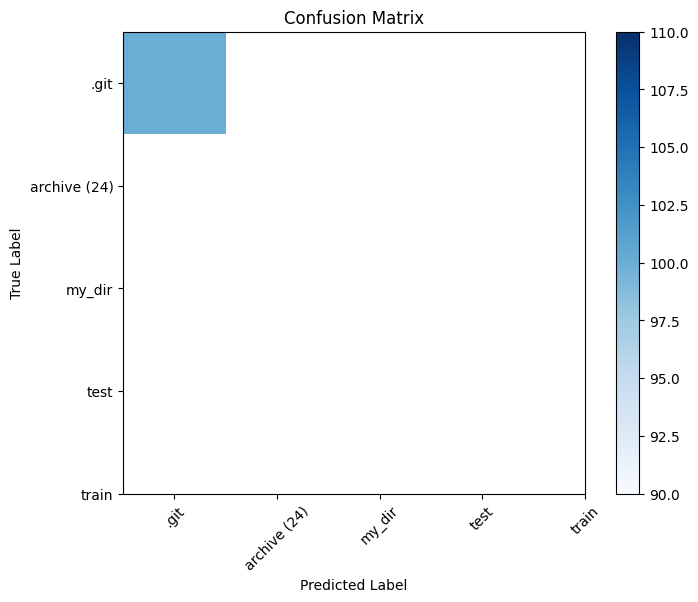

Fine-tuning VGG16 Model...
Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 1.0000 - loss: 0.0886 - val_accuracy: 1.0000 - val_loss: 0.0411 - learning_rate: 1.0000e-05
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 1.0000 - loss: 0.0554 - val_accuracy: 1.0000 - val_loss: 0.0215 - learning_rate: 1.0000e-05
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 1.0000 - val_loss: 0.0099 - learning_rate: 1.0000e-05
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 1.0000 - loss: 0.0140 - val_accuracy: 1.0000 - val_loss: 0.0052 - learning_rate: 1.0000e-05
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 1.0000e-05
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0014 - learning_rate: 1.0000e-05
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 1

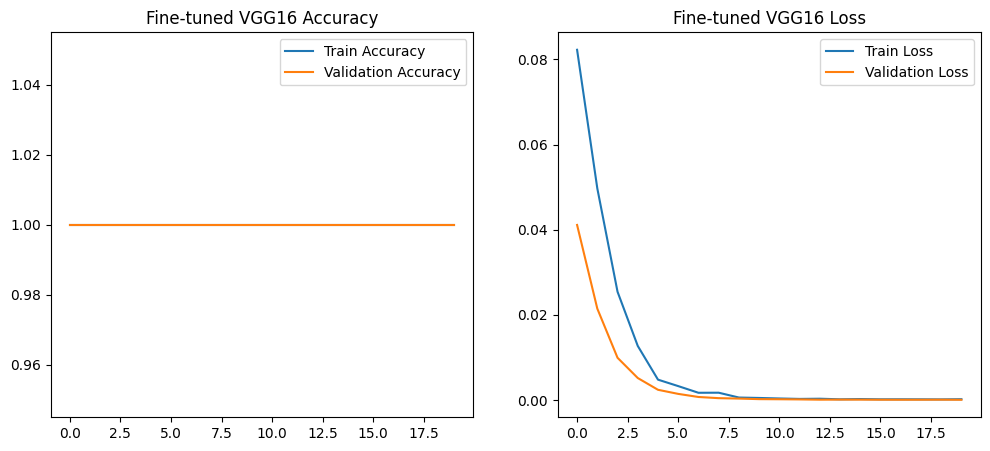

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the test data
test_gen = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset=None  # Use the remaining dataset for testing
)

# Evaluate the models on the test data
print("Evaluating VGG16 Model...")
vgg16_eval = vgg16_model.evaluate(test_gen, verbose=1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(vgg16_eval[0], vgg16_eval[1] * 100))

print("Evaluating InceptionV3 Model...")
inceptionv3_eval = inceptionv3_model.evaluate(test_gen, verbose=1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(inceptionv3_eval[0], inceptionv3_eval[1] * 100))

print("Evaluating Xception Model...")
xception_eval = xception_model.evaluate(test_gen, verbose=1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(xception_eval[0], xception_eval[1] * 100))

# Generate predictions and evaluate classification metrics
y_pred_vgg16 = np.argmax(vgg16_model.predict(test_gen), axis=1)
y_true = test_gen.classes

# Ensure that the labels parameter is correctly set for multi-class classification
class_labels = list(test_gen.class_indices.keys())  # Get class labels from the data generator

# Classification report for VGG16
print("Classification Report for VGG16 Model:")
print(classification_report(y_true, y_pred_vgg16, target_names=class_labels, labels=np.arange(len(class_labels))))

# Confusion Matrix for VGG16
cm = confusion_matrix(y_true, y_pred_vgg16)
print("Confusion Matrix for VGG16 Model:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels)), class_labels)
plt.show()

# Fine-tune the VGG16 Model
print("Fine-tuning VGG16 Model...")
for layer in vgg16_base.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

# Compile the fine-tuned model
vgg16_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks for early stopping and learning rate adjustment
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7)
]

# Train the fine-tuned model
history_fine_tune = vgg16_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

# Re-evaluate the fine-tuned model
print("Re-evaluating Fine-tuned VGG16 Model...")
fine_tuned_eval = vgg16_model.evaluate(test_gen, verbose=1)
print("Fine-tuned Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(fine_tuned_eval[0], fine_tuned_eval[1] * 100))

# Plot the fine-tuned model's learning curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title("Fine-tuned VGG16 Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title("Fine-tuned VGG16 Loss")
plt.legend()

plt.show()


Found 100 images belonging to 5 classes.
Evaluating VGG16 Model...


c:\Users\shamb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step
VGG16 Accuracy: 100.00%
VGG16 F1 Score: 1.0000


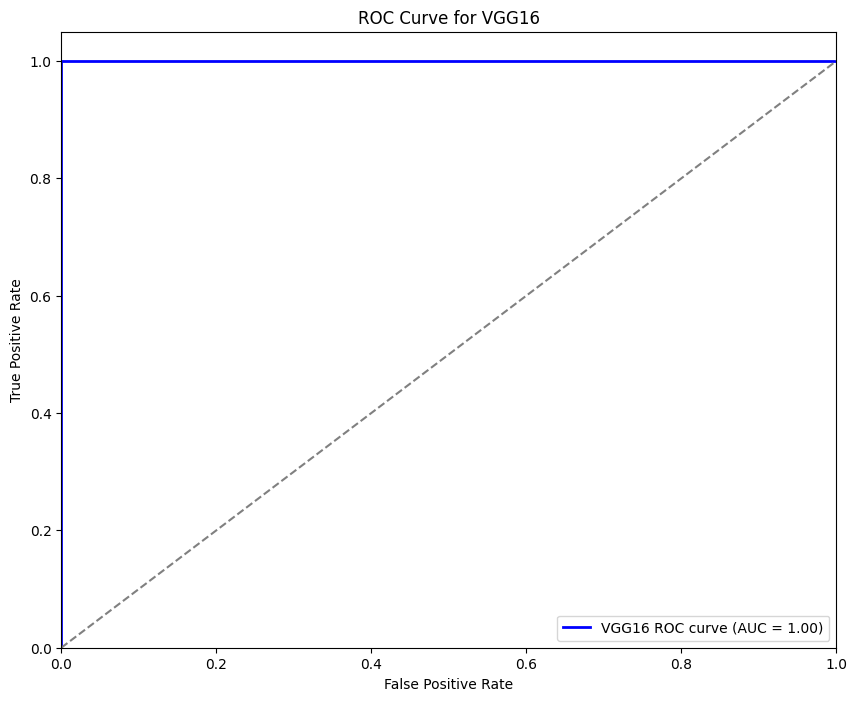

Evaluating InceptionV3 Model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
InceptionV3 Accuracy: 30.00%
InceptionV3 F1 Score: 0.4615


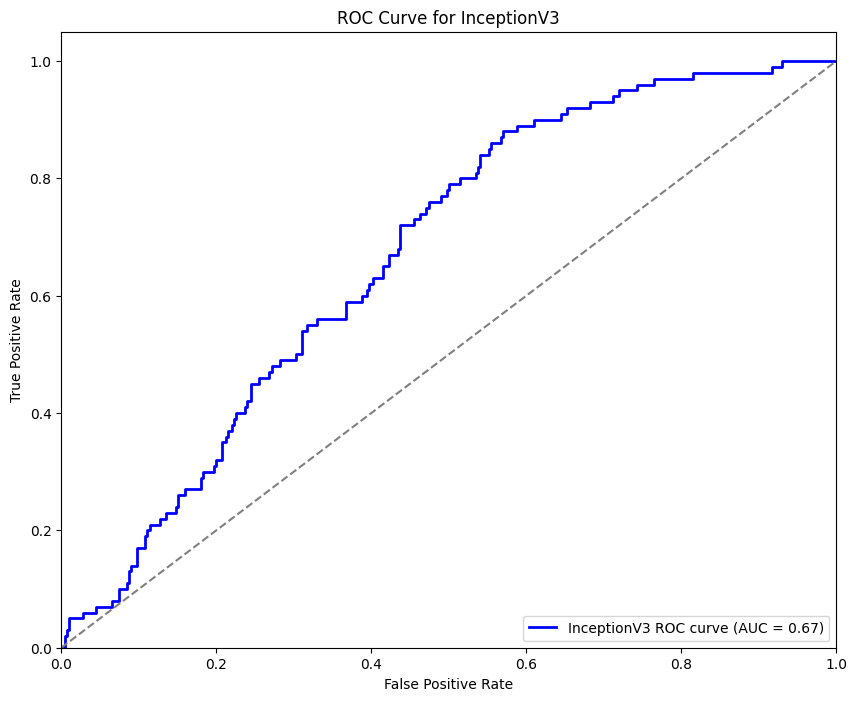

Evaluating Xception Model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Xception Accuracy: 57.00%
Xception F1 Score: 0.7261


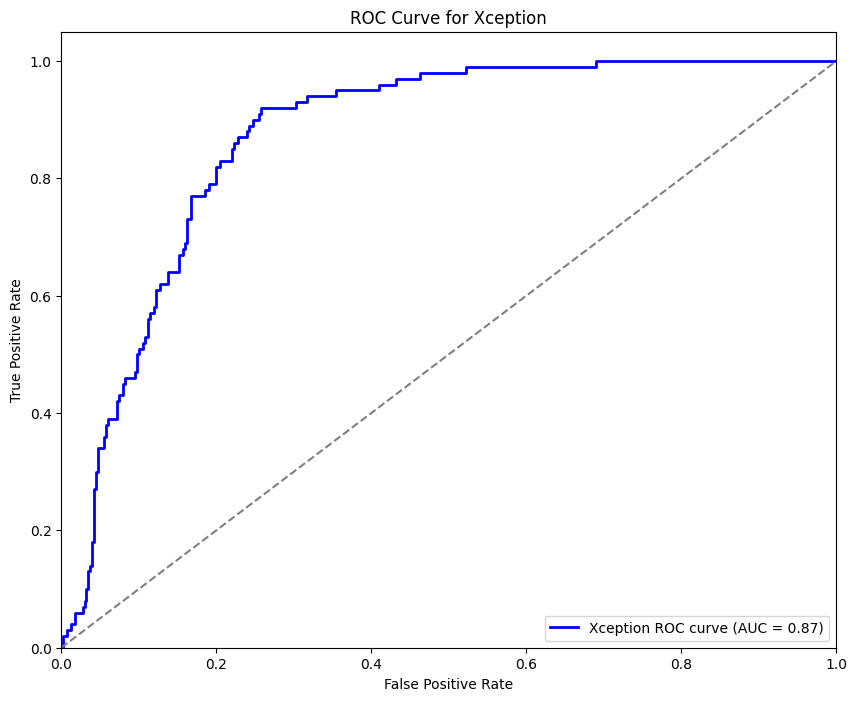

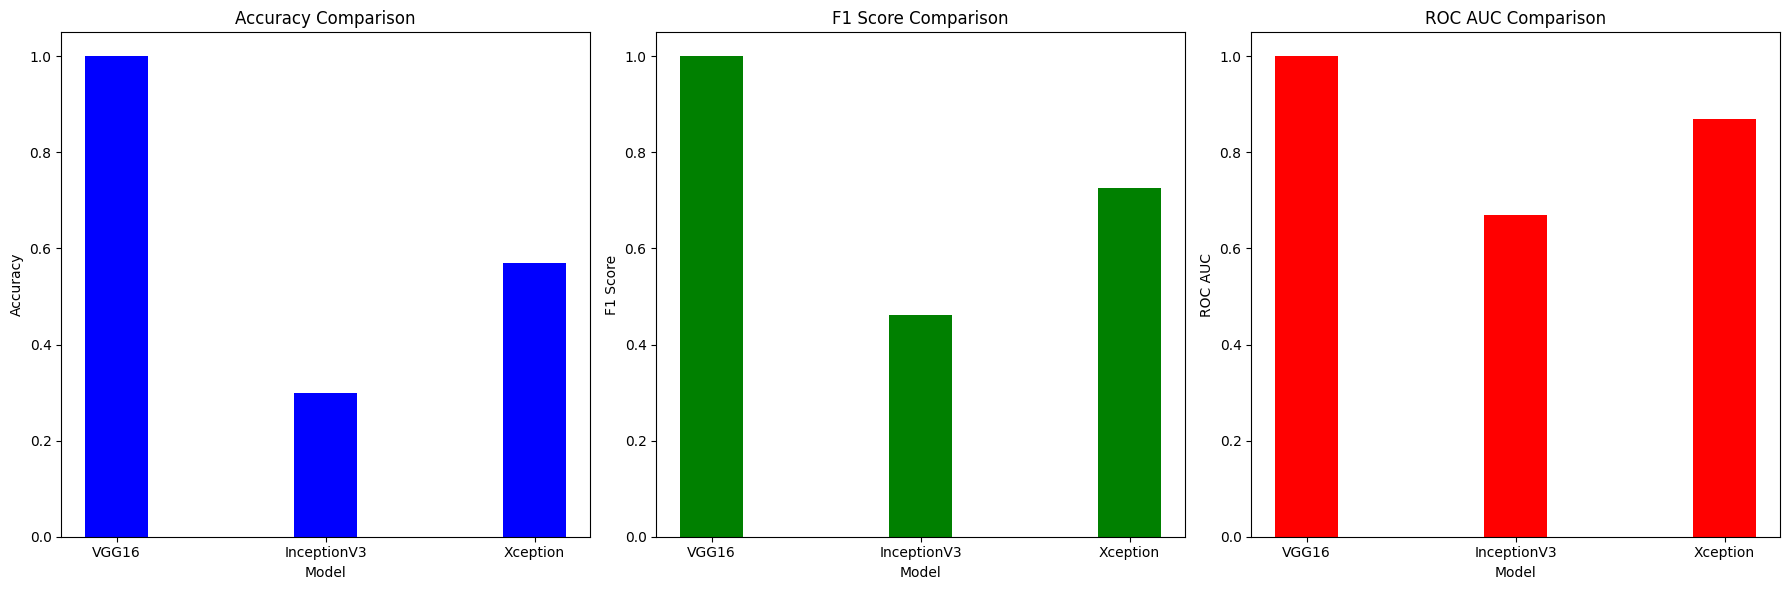

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test data generator
test_gen = datagen.flow_from_directory(
    directory=data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # Use 'categorical' for multi-class classification
    subset=None  # Use the remaining dataset for testing
)

def evaluate_metrics(model, model_name, test_gen):
    print(f"Evaluating {model_name} Model...")

    # Get true labels
    y_true = test_gen.classes
    # Get class labels from the data generator
    class_labels = list(test_gen.class_indices.keys())

    # Get predictions and probabilities
    y_pred_prob = model.predict(test_gen)  # Probabilities for each class
    y_pred = np.argmax(y_pred_prob, axis=1)  # Predicted class indices

    # Calculate Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy * 100:.2f}%")

    # Calculate F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{model_name} F1 Score: {f1:.4f}")

    # Compute ROC curve and ROC AUC for each class
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_labels)))  # Binarize the true labels
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC

    # Plot ROC Curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'{model_name} ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, f1, roc_auc

# Initialize lists to store the metrics for all models
accuracies = []
f1_scores = []
roc_aucs = []

# Evaluate models and store metrics
accuracy_vgg16, f1_vgg16, roc_auc_vgg16 = evaluate_metrics(vgg16_model, "VGG16", test_gen)
accuracies.append(accuracy_vgg16)
f1_scores.append(f1_vgg16)
roc_aucs.append(roc_auc_vgg16)

accuracy_inceptionv3, f1_inceptionv3, roc_auc_inceptionv3 = evaluate_metrics(inceptionv3_model, "InceptionV3", test_gen)
accuracies.append(accuracy_inceptionv3)
f1_scores.append(f1_inceptionv3)
roc_aucs.append(roc_auc_inceptionv3)

accuracy_xception, f1_xception, roc_auc_xception = evaluate_metrics(xception_model, "Xception", test_gen)
accuracies.append(accuracy_xception)
f1_scores.append(f1_xception)
roc_aucs.append(roc_auc_xception)

# Plot the metrics for all models in a graph
x = np.arange(len(accuracies))  # X-axis positions for models
width = 0.3  # Bar width

# Create subplots for bar graphs
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot Accuracy
ax[0].bar(x, accuracies, width, color='b', align='center')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(['VGG16', 'InceptionV3', 'Xception'])

# Plot F1 Score
ax[1].bar(x, f1_scores, width, color='g', align='center')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('F1 Score')
ax[1].set_title('F1 Score Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(['VGG16', 'InceptionV3', 'Xception'])

# Plot ROC AUC
ax[2].bar(x, roc_aucs, width, color='r', align='center')
ax[2].set_xlabel('Model')
ax[2].set_ylabel('ROC AUC')
ax[2].set_title('ROC AUC Comparison')
ax[2].set_xticks(x)
ax[2].set_xticklabels(['VGG16', 'InceptionV3', 'Xception'])

plt.tight_layout()
plt.show()
